# Regression Coefficients Nullspace Perspective
This notebook contains contains examples and visualizations of the nullspace perspective for regression in high dimensions. 
Corresponding paper: 

Contact: Joachim Schaeffer, joachim.schaeffer@posteo.de

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression

# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import Layout, interact, interactive

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(42)

# Custom functions
import src.basis as basis
from src.data_gen import generate_target_values

from src.helper import construct_data
from src.helper import construct_plot_data_interactive
from src.helper import optimise_pls_cv

In [2]:
# Varibles to set. 
# Paths are OS dependent.

# Shall plots be saved?
save_plots = True

# Path to save plots
save_plot_path = './../Nullspace/Figures/' 
# save_plot_path = './results/' 

plt.style.use('./styles/plots.mplstyle')

# Plot additional visualizations.
extra_plots = 0

# Load data that was used for the publication
# Is set to true, the data for the plots will be loaded from csv files. 
# If set to false the data will be generated and figures might differ slightly due to the random structure of the noise.
load_data = True

# If load data=False and save_data=True, the csv files will be replaced with the data genearated during this run.
save_data = False

#### Example of basis function usage!

In [3]:
if 0:
    x_min = -np.pi/4
    x_max = +np.pi/4

    # Random parameter values based on normal distributed values
    means = [1, 1, 0.5, 0.1, 0.1]
    stdv = [2, 2, 0.2, 0.1, 0.1]
    # Draw the parameters for the matrix
    # m = np.random.uniform(low=range_m[0], high=range_m[1], size=rows)

    basis_obj = construct_data(x_min, x_max, basis.polynomial, means, stdv,
                               num_datapoints=50, draws=10, plot_results=1)

In [4]:
if extra_plots:
        slider_length = '85%'

        interactive(construct_plot_data_interactive,
                basis_function = ipywidgets.Dropdown(
                                        options=[(basis.fourier), (basis.polynomial), (basis.relu)],
                                        value=(basis.polynomial),
                                        description='Function Basis'),
                x_min = ipywidgets.FloatSlider(
                                        value=-2,
                                        min=-10,
                                        max=10,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='X_min',
                                        continuous_update=False),
                x_max = ipywidgets.FloatSlider(
                                        value=5,
                                        min=-10,
                                        max=10,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='X_max',
                                        continuous_update=False),
                mean_param0 = ipywidgets.FloatSlider(
                                        value=0,
                                        min=0,
                                        max=10,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='mean_0',
                                        continuous_update=False),
                mean_param1 = ipywidgets.FloatSlider(
                                        value=1,
                                        min=0,
                                        max=7,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='mean_1',
                                        continuous_update=False),
                mean_param2 = ipywidgets.FloatSlider(
                                        value=1,
                                        min=0,
                                        max=4,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='mean_2',
                                        continuous_update=False),
                stdv_params0 = ipywidgets.FloatSlider(
                                        value=0,
                                        min=0,
                                        max=7,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='std_0',
                                        continuous_update=False),
                stdv_params1 = ipywidgets.FloatSlider(
                                        value=1,
                                        min=0,
                                        max=7,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='std_1',
                                        continuous_update=False),
                stdv_params2 = ipywidgets.FloatSlider(
                                        value=1,
                                        min=0,
                                        max=7,
                                        step=0.00001,
                                        layout = Layout(width=slider_length),
                                        description='std_2',
                                        continuous_update=False),
                num_datapoints = ipywidgets.IntSlider(
                                        value=50,
                                        min=10,
                                        max=200,
                                        layout = Layout(width=slider_length),
                                        description='cols',
                                        continuous_update=False),
                draws = ipywidgets.IntSlider(
                                        value=50,
                                        min=1,
                                        max=200,
                                        layout = Layout(width=slider_length),
                                        description='draws',
                                        continuous_update=False)
                )

#### Generate Synthethic
Showcase of the Nullspace methodology on different examples.

Generate Synthethic dataset, using SynMLData class that inherits form the basis class. 

Example I: Linear basis function

In [5]:
means = [0, 0.2]
stdv = [0, 0.15]
x_min = 1
x_max = 5

# Data without noise. dml: Data machine learning
dml_linear = construct_data(
    x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

# Data with noise.
dml_linear_n = construct_data(
    x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

# Example Case I: 
# The true feature is the mean.
mean_function = lambda a : np.mean(a, axis=1)

dml_linear = dml_linear.construct_y_data(mean_function)
dml_linear_n = dml_linear_n.construct_y_data(mean_function)

dml_linear_n = dml_linear_n.add_wgn(add_noise_X=True, snr_x=50, add_noise_y=True, snr_y=50)


mean_reg_coef = (1/dml_linear.X.shape[1]) * np.ones(dml_linear.X.shape[1])
    

In [6]:
# Machine Learning models that are used to compare regression coefficients. 
# The hyperparameters are chosen conservatively here to showcase the method. 
# Alternatively, use cross validation.
model_PLS1 = PLSRegression(n_components=1, tol=1e-7, scale=False)
model_rr0p3 = Ridge(alpha=0.3)

# Learn the weights (aka regression coefficients), using the models defined above.
dml_linear = dml_linear.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_linear = dml_linear.learn_weights(model_rr0p3, 'RR lambda 0.3')

dml_linear_n = dml_linear_n.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_linear_n = dml_linear_n.learn_weights(model_rr0p3, 'RR lambda 0.3')

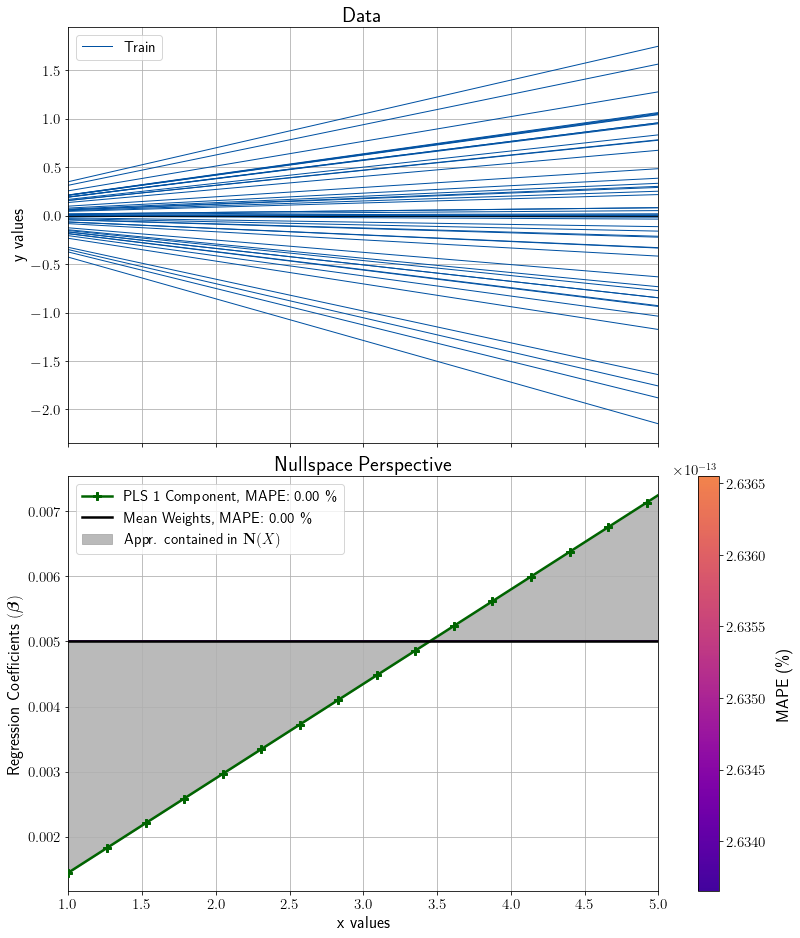

In [7]:
dml_linear, fig, ax = dml_linear.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='Linear_example.pdf')

In [8]:
# Visualize standardized data.
if extra_plots: 
    plt.plot(dml_linear.x, dml_linear.X_std.T)
    plt.title('Data Standardized')
    plt.show()

In [9]:
# Visualize regression coefficients for the standardized data. 
if extra_plots: 
    plt.plot(dml_linear.x, dml_linear.weights['PLS 1 Comp. std'], label='Reg Std')
    plt.plot(dml_linear.x, mean_reg_coef*dml_linear.std, label='Mean std_trans')
    plt.legend()
    plt.show()
    # Conclusion: Coefficients on standardized might lead to more realistic shapes because they are not affected by the nullspace. 
    # However, retransforming them into to 'non' standardized case will makee it more difficutl to interpret them because a combination of standard deviation and regularization will lead ot coefficients that might not be very useful!
    # It should be shown on other examples that this preliminary assumption holds true. 

In [10]:
# Visualize regression coefficients for the standardized data retransformed to make predictions with the origianl data.
if extra_plots:
    plt.plot(dml_linear.x, dml_linear.weights['PLS 1 Comp. std']/dml_linear.std, label='Std retrans') 
    plt.plot(dml_linear.x, dml_linear.weights['PLS 1 Comp.'], label='No std')
    plt.plot(dml_linear.x, mean_reg_coef, label='Mean')
    plt.legend()

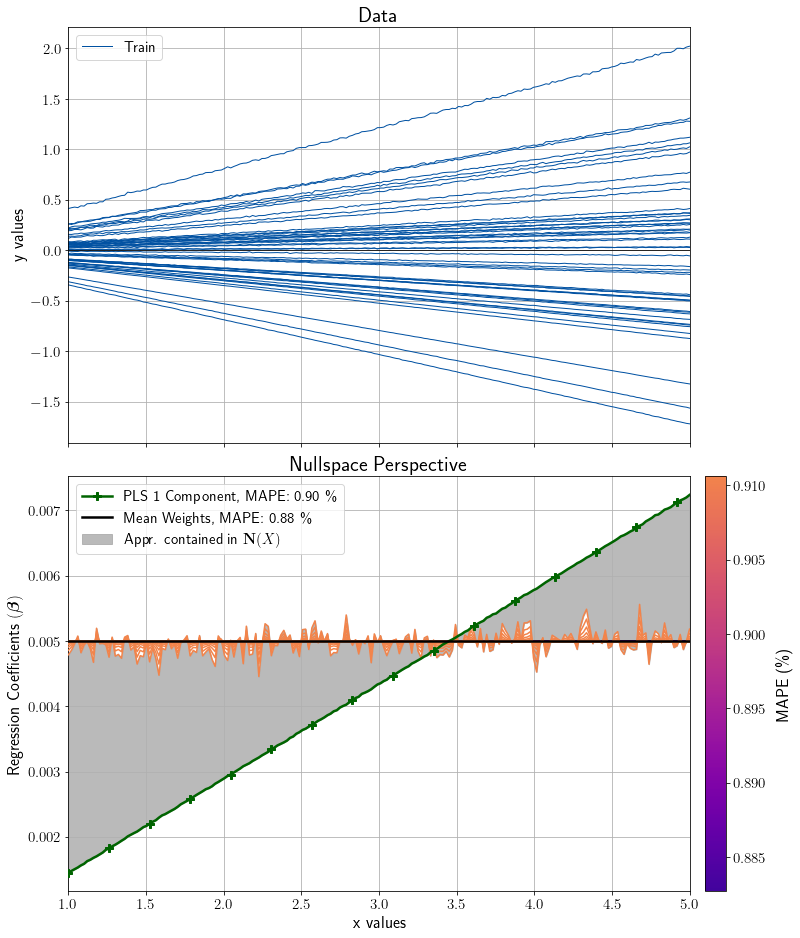

In [11]:
dml_linear_n, fig, ax = dml_linear_n.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='Linear_example_noise.pdf')

Example II: Parabolas

In [12]:
if not load_data:
    x_min = 1.0
    x_max = 3.0
    means = [0, 0, 0.3]
    stdv = [0, 0, 0.3]
    x = np.linspace(x_min, x_max, 200)[:, None]

    # Data without noise
    dml_parab = construct_data(
        x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

    # Data with noise
    dml_parab_n = construct_data(
        x_min, x_max, basis.polynomial, means, stdv, objtype='mldata', num_datapoints=200, draws=50, plot_results=0)

    # True feature is the mean
    mean_function = lambda a : np.mean(a, axis=1)

    dml_parab = dml_parab.construct_y_data(mean_function)
    dml_parab_n = dml_parab_n.construct_y_data(mean_function)
    dml_parab_n = dml_parab_n.add_wgn(add_noise_X=True, snr_x=50, add_noise_y=True, snr_y=50)

    if save_data: 
        np.savetxt(
            "dml_parab.csv", np.hstack((dml_parab.X, np.expand_dims(dml_parab.y, axis=1))), delimiter=",", 
            header="Col. 0-49 X, poly. basis params.: means = [0, 0, 0.3], stdv = [0, 0, 0.3], y col. 50, sample mean, prior to noise")
        np.savetxt(
            "dml_parab_n.csv", np.hstack((dml_parab_n.X, np.expand_dims(dml_parab_n.y, axis=1))), delimiter=",", 
            header="Col. 0-49 X, poly. basis params.: means = [0, 0, 0.3], stdv = [0, 0, 0.3], y col. 50, sample mean, prior to noise")
else: 
    temp = np.loadtxt('dml_parab.csv', skiprows=1, delimiter=',') 
    temp_n = np.loadtxt('dml_parab_n.csv', skiprows=1, delimiter=',') 
    # Parameters from header ofcsv file
    x = np.linspace(1.0, 3.0, temp[:,:-1].shape[1])[:, None]

    dml_parab = basis.SynMLData(None, None).place_X_y(temp[:,:-1], x, temp[:,-1])
    dml_parab_n = basis.SynMLData(None, None).place_X_y(temp_n[:,:-1], x, temp_n[:,-1])

mean_reg_coef = (1/dml_parab.X.shape[1]) * np.ones(dml_parab.X.shape[1])

In [13]:
# Learn the weights (aka regression coefficients), using the models defined above.
dml_parab = dml_parab.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_parab = dml_parab.learn_weights(model_rr0p3, 'RR lambda 0.3')

dml_parab_n = dml_parab_n.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_parab_n = dml_parab_n.learn_weights(model_rr0p3, 'RR lambda 0.3')

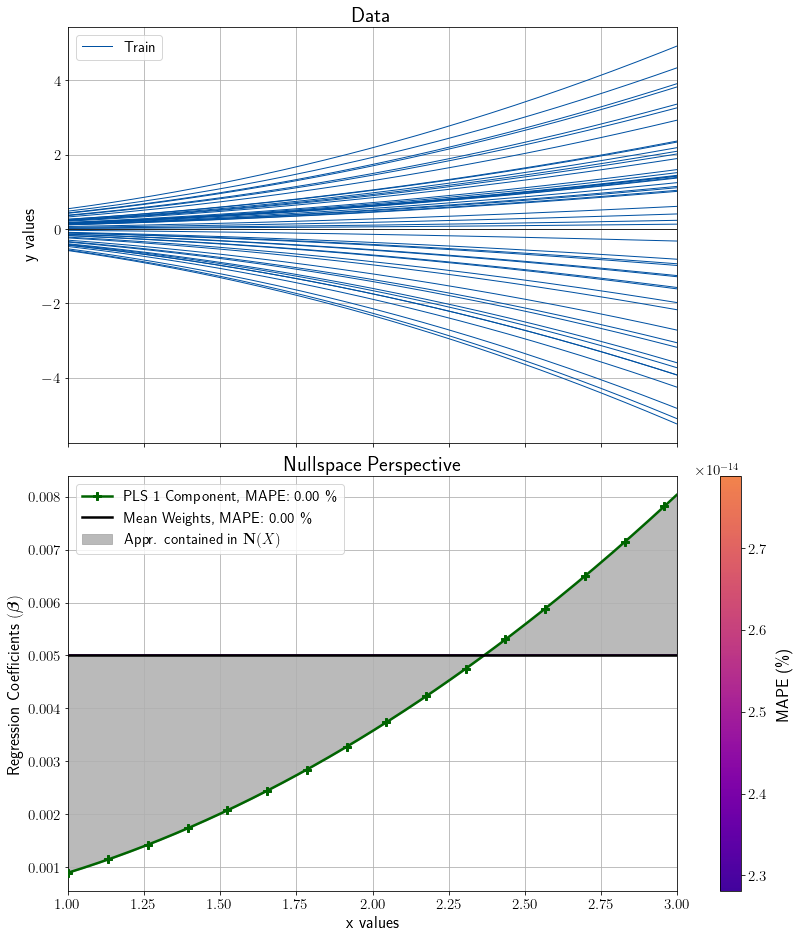

In [14]:
dml_parab, fig, ax = dml_parab.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='Polynomial_example.pdf')

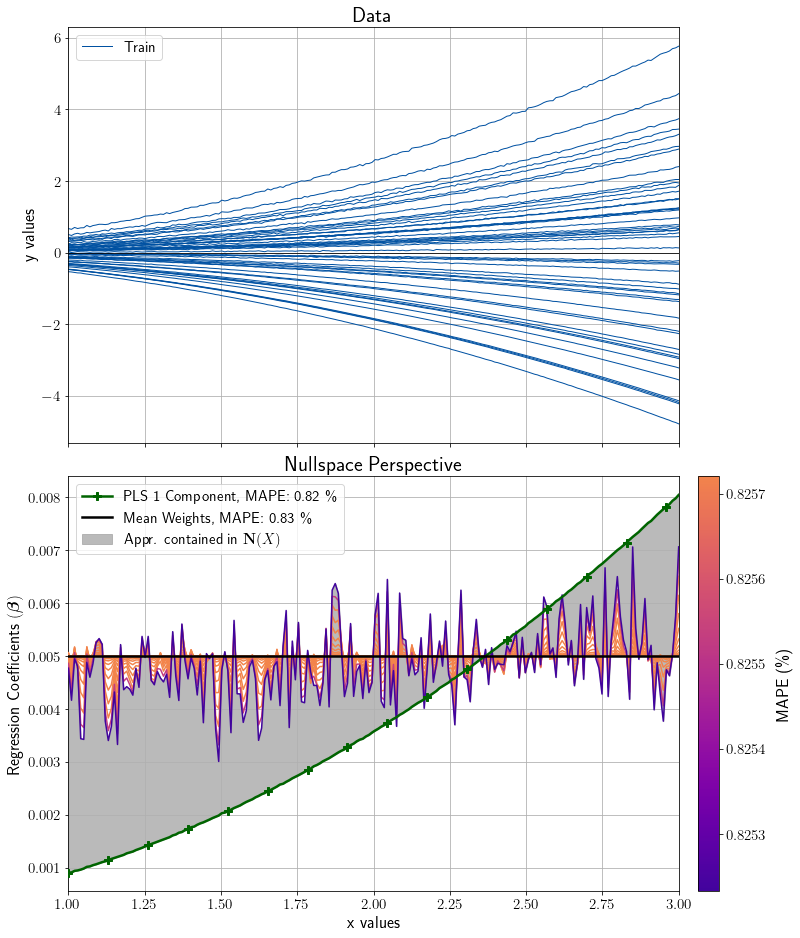

In [15]:
dml_parab_n, fig, ax = dml_parab_n.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef, w_beta_name='Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='Polynomial_example_noise.pdf')

# ax[1].plot(dml_parab.x, dml_parab.weights_std['PLS 1 Comp. std'])
# ax[1].plot(dml_parab.x, dml_parab.weights_std_retrans['PLS 1 Comp. std retrans'])
# if save_plots:
#     fig.savefig(save_plot_path + 'Polynomial_example_noise.pdf')

Example from LAVADE:

More details about this test case in the publication:

LATENT VARIABLE METHOD DEMONSTRATOR - SOFTWARE FOR UNDERSTANDING MULTIVARIATE DATA ANALYTICS ALGORITHMS

https://arxiv.org/pdf/2205.08132.pdf

In [16]:
# Method translated from MATLAB code
# https://github.com/JoachimSchaeffer/LAVADE

# Parameters
means = np.array([2, -1, -4, -5])
stds = np.array([0, 2, 2, 0])

samples = 60
measurement_points = 150
points_left = 60
points_middle = 30 
point_right = measurement_points-points_left-points_middle

start_value = np.random.normal(means[0], stds[0], samples)
target_left = np.random.normal(means[1], stds[1], samples)
target_right = np.random.normal(means[2], stds[2], samples)
final_value = np.random.normal(means[3], stds[3], samples)

rand_uc_l = np.zeros((samples, points_left))
rand_uc_r = np.zeros((samples, point_right))
signal = np.zeros((samples, points_middle))

# Algorithm from LAVADE
for i in range(samples):
    rand_uc_l[i, :] = np.linspace(start_value[i], target_left[i], points_left)
    rand_uc_r[i, :] = np.linspace(target_right[i], final_value[i], point_right)
    signal[i, :] =  np.linspace(target_left[i], target_right[i], points_middle)

# Build the datamatrix X
X_lavade = np.hstack((rand_uc_l[:, :-1], signal, rand_uc_r[:, 1:]))
x_lavade = np.linspace(0, measurement_points-3, measurement_points-2)
y_lavade = (target_right-target_left)/points_middle

# Contruct data object
dml_LAVADE_ex = basis.SynMLData(None, None)
dml_LAVADE_ex = dml_LAVADE_ex.place_X_y(X_lavade, x_lavade, y_lavade)

# Another way:
# y_lavade = lambda X : (X[:, points_left+points_middle-2]-X[:, points_left-1])/points_middle
# y_lavade = lambda X : (X[:, 60+30-2]-X[:, 60-1])/30

In [17]:
if extra_plots:
    plt.plot(x_lavade, X_lavade.T)
    plt.title('LAVADE Example')
    plt.xlabel('x values ()')
    plt.ylabel('y values ()')
    plt.show()

In [18]:
# Compare RR and lasso
model_PLS2 = PLSRegression(n_components=2, tol=1e-7, scale=False)
model_PLS3 = PLSRegression(n_components=3, tol=1e-7, scale=False)
model_PLS4 = PLSRegression(n_components=4, tol=1e-7, scale=False)
model_rr_lavade = Ridge(alpha=10**(-6))
model_lasso_lavade = Lasso(alpha=0.00015)

dml_LAVADE_ex = dml_LAVADE_ex.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_LAVADE_ex = dml_LAVADE_ex.learn_weights(model_rr_lavade, 'RR lambda 10e-6')
dml_LAVADE_ex = dml_LAVADE_ex.learn_weights(model_lasso_lavade, 'lasso lambda 0.00015')

/Users/joachim/Documents/PhD/PhD_Material/02Research/Papers/02Nullspace/HDFeat/src/basis.py:168: RuntimeWarning: invalid value encountered in true_divide
  self.X_std = self.X_ / self.std
/Users/joachim/Documents/PhD/PhD_Material/02Research/Papers/02Nullspace/HDFeat/src/basis.py:168: RuntimeWarning: invalid value encountered in true_divide
  self.X_std = self.X_ / self.std
/Users/joachim/Documents/PhD/PhD_Material/02Research/Papers/02Nullspace/HDFeat/src/basis.py:168: RuntimeWarning: invalid value encountered in true_divide
  self.X_std = self.X_ / self.std
/Users/joachim/opt/anaconda3/envs/featlin/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.954e-04, tolerance: 6.757e-05
  model = cd_fast.enet_coordinate_descent(


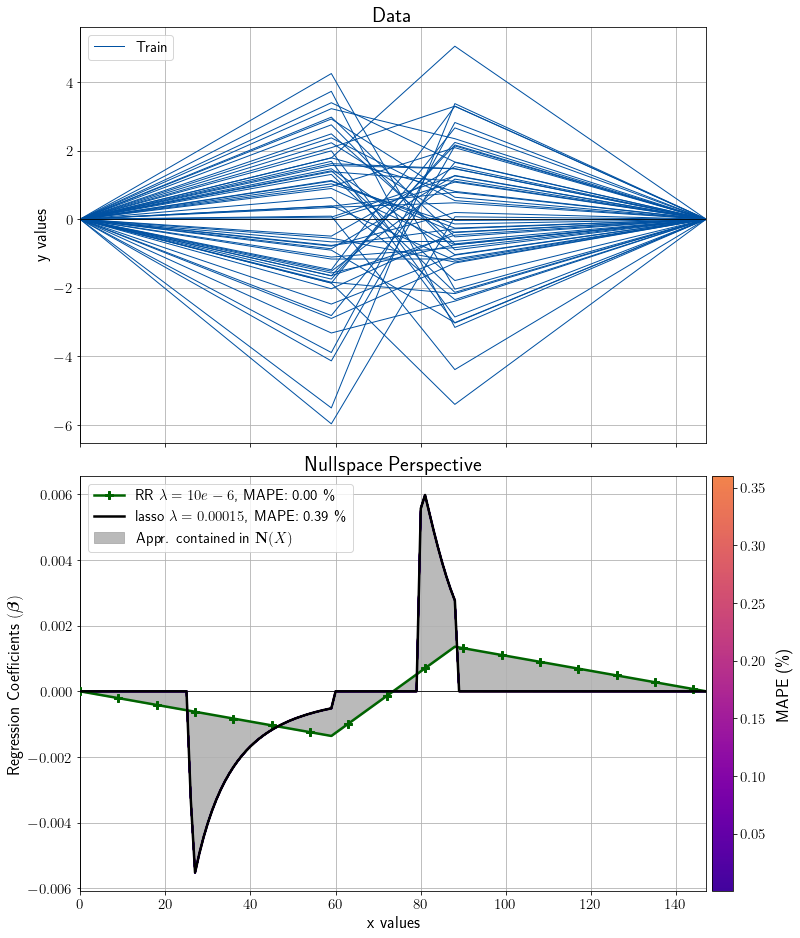

In [19]:
dml_LAVADE_ex, fig, ax = dml_LAVADE_ex.nullspace_correction(
    key_alpha = 'RR lambda 10e-6', w_alpha_name=r'RR $\lambda=10e-6$', 
    key_beta = 'lasso lambda 0.00015', w_beta_name=r'lasso $\lambda=0.00015$', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LAVADE_example.pdf')

# Example using LFP Data:

published with:
Data-driven prediction of battery cycle life before capacity degradation

https://www.nature.com/articles/s41560-019-0356-8

Source of data: 
https://data.matr.io/

License of LFP data: lfpdatalicense.txt

In [20]:
# Load the LFP Dataset
lfp_df = pd.read_csv('lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])    
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
# X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
# y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
# X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
# y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

y_lfp_train_syn = np.zeros(X_lfp_train.shape[0])
mean_function = lambda a: np.mean(a)
mean_reg_coef_lfp = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])

if not load_data: 
    y_lfp_train_syn = generate_target_values(X_lfp_train, mean_function, percentage_range_x_to_t=[0,1])
    # Contruct data object
    dml_lfp_syn = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfp_train_syn)
    # Add noise to target values
    dml_lfp_syn = dml_lfp_syn.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)
    if save_data: 
        np.savetxt(
            "lfp_y_mean.csv", dml_lfp_syn.y, delimiter=",", 
            header="Sample Mean reposne for the LFP Data")
else:
    dml_lfp_syn = basis.SynMLData(None, None).place_X_y(
        X_lfp_train, x_lfp, np.loadtxt('lfp_y_mean.csv', skiprows=1, delimiter=','))

In [21]:
np.savetxt(
    "lfp_y_mean.csv", dml_lfp_syn.y, delimiter=",", 
    header="Sample Mean reposne for the LFP Data")

In [22]:
# LFP dataset synthethic y
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS4, 'PLS 4 Comp.')
dml_lfp_syn = dml_lfp_syn.learn_weights(model_PLS4, 'PLS 5 Comp.')

(array([2.20219500e-07, 2.68426469e-08, 1.08407823e-08, 8.03511222e-09,
        7.93890872e-09, 1.08823227e-08, 1.62787852e-08, 1.65140416e-08,
        1.74363892e-08, 2.20624470e-08]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

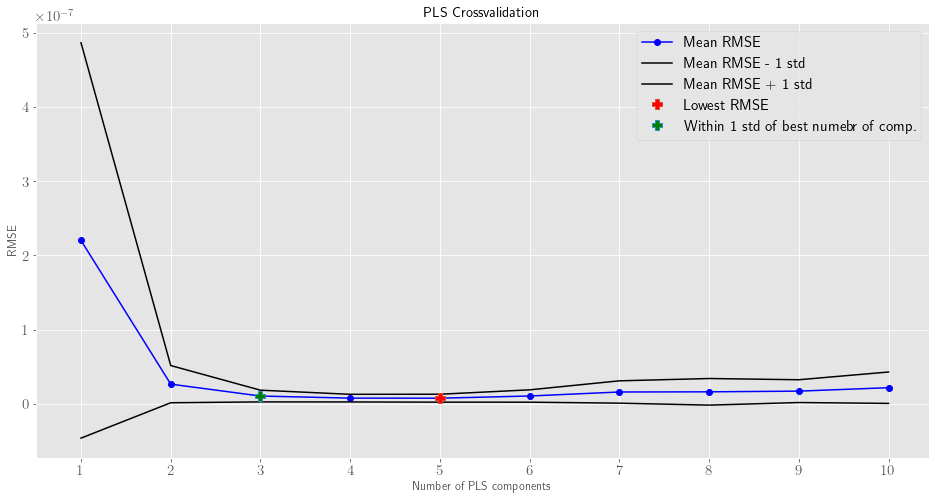

In [23]:
optimise_pls_cv(dml_lfp_syn.X_, dml_lfp_syn.y_, max_comps=10, plot_components=True, std=False)

(array([6.77048228e-07, 2.16754033e-07, 2.33415751e-08, 1.11521714e-08,
        6.88861331e-09, 9.69692807e-09, 1.36864727e-08, 1.96430159e-08,
        2.07993452e-08, 2.31247646e-08]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

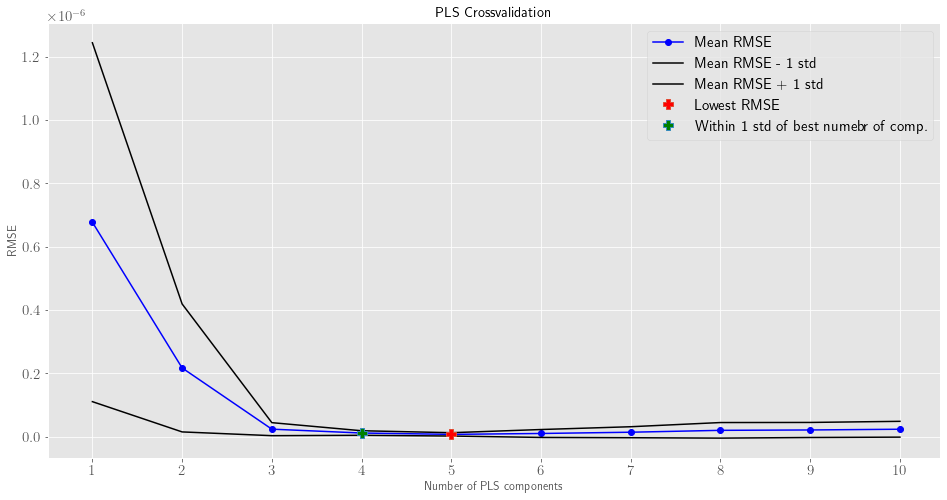

In [24]:
optimise_pls_cv(dml_lfp_syn.X_, dml_lfp_syn.y_, max_comps=10, plot_components=True, std=True)

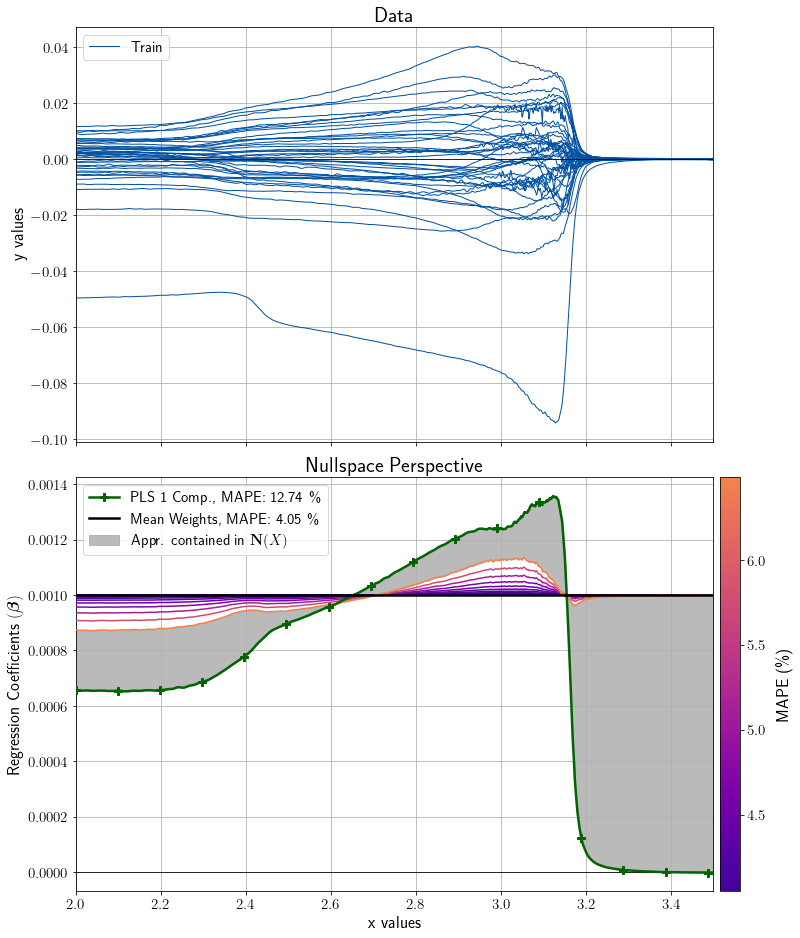

In [25]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 1 Comp.', w_alpha_name='PLS 1 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False, 
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_1PLS_mean.pdf')

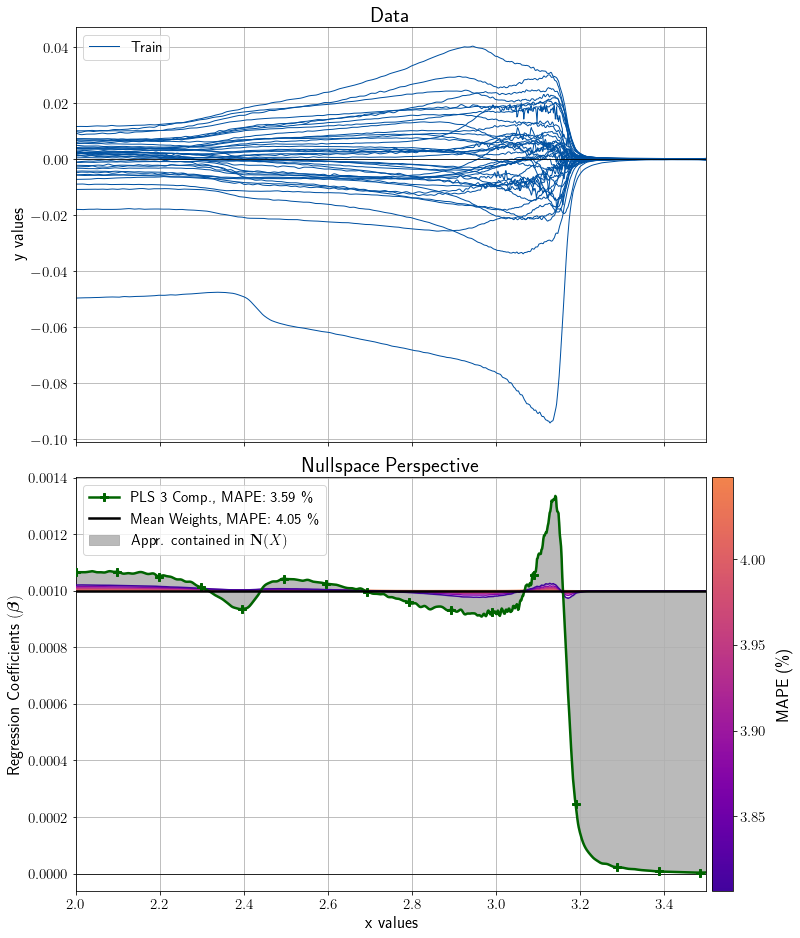

In [26]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 3 Comp.', w_alpha_name='PLS 3 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False, 
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_3PLS_mean.pdf')

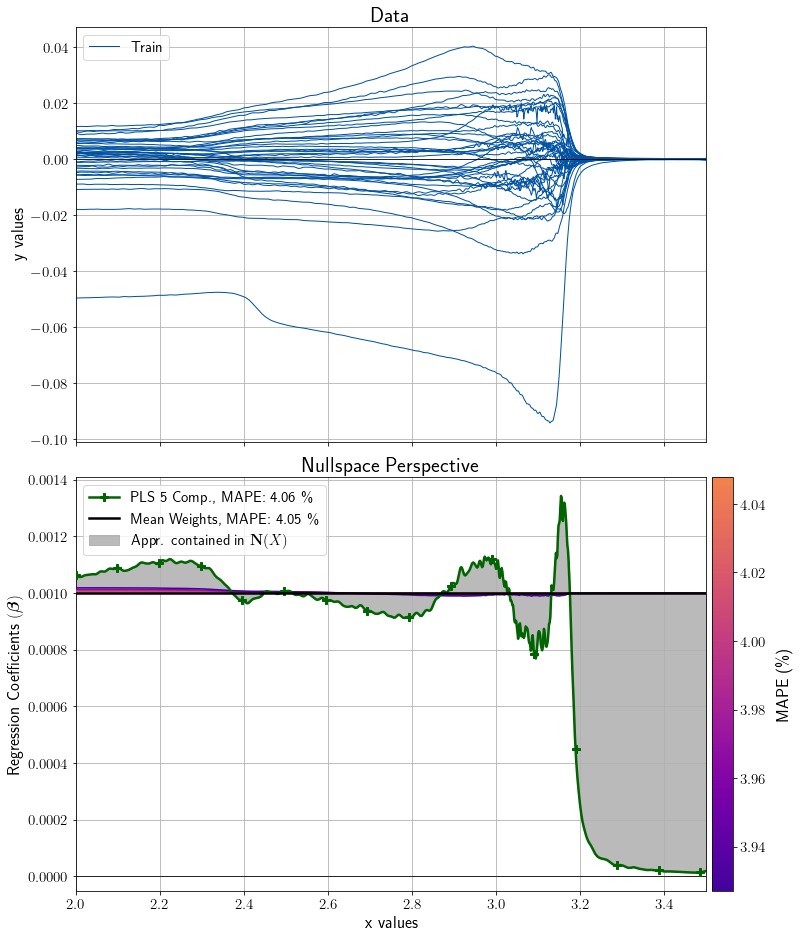

In [27]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha ='PLS 5 Comp.', w_alpha_name='PLS 5 Comp.', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=False, 
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_4PLS_mean.pdf')

In [28]:
if extra_plots:
    plt.scatter(dml_lfp_syn.X@mean_reg_coef_lfp, dml_lfp_syn.X@dml_lfp_syn.weights['PLS 1 Comp.']+dml_lfp_syn.X@dml_lfp_syn.nullsp['v_'][-1, :])

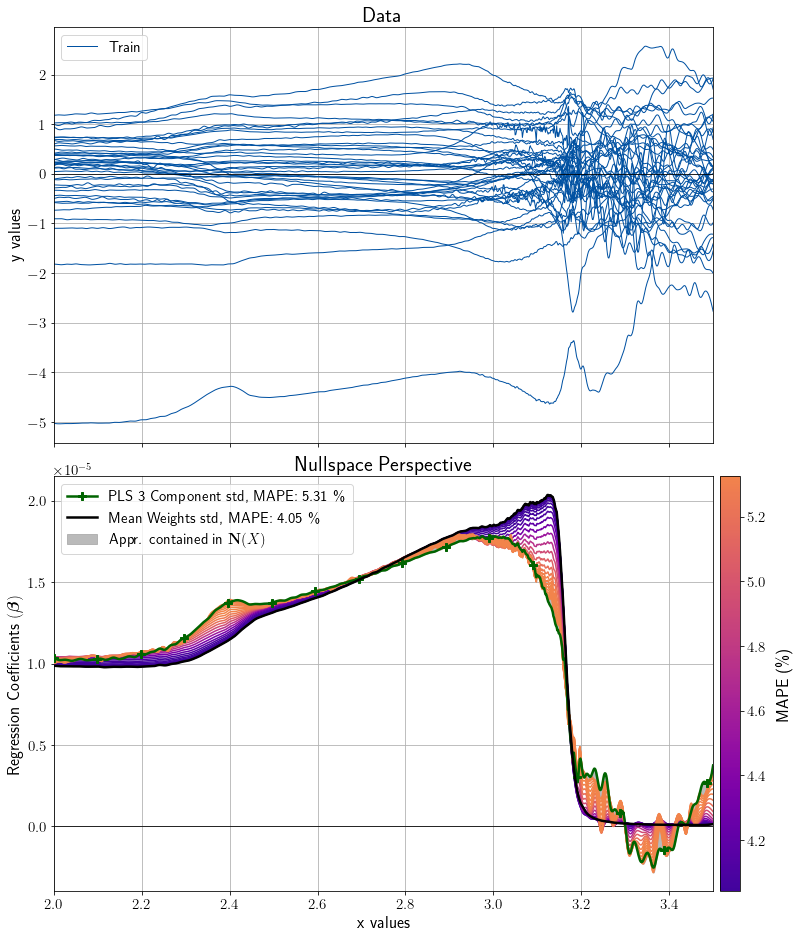

In [29]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha = 'PLS 3 Comp.', w_alpha_name='PLS 3 Component', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_std_3PLS_mean.pdf')

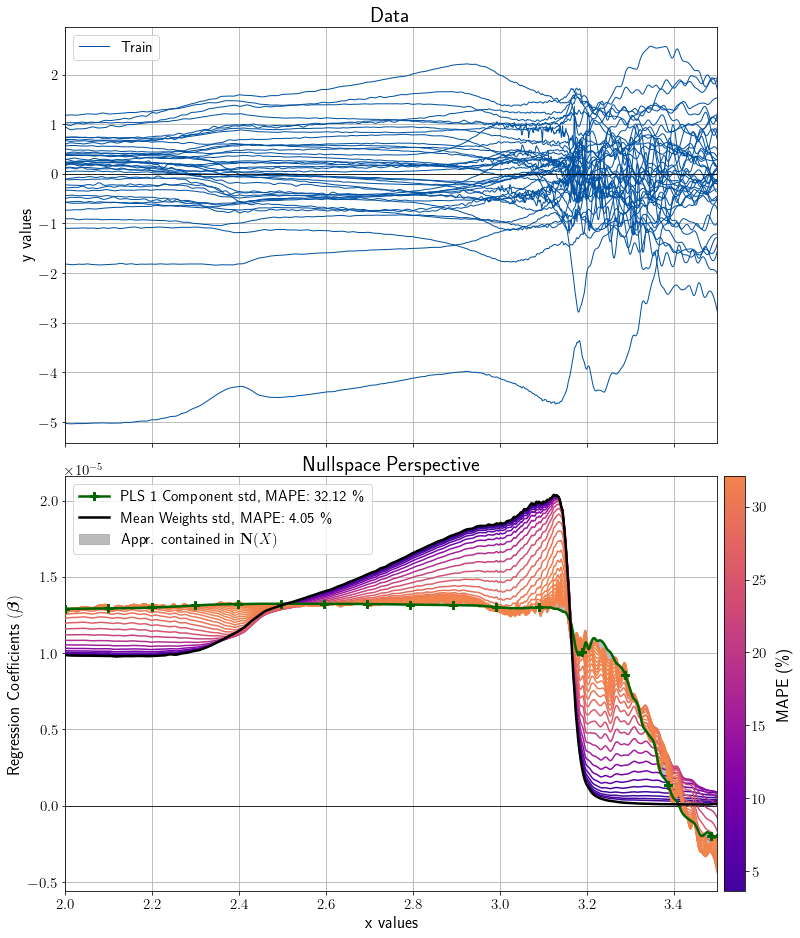

In [30]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_std_1PLS_mean.pdf')

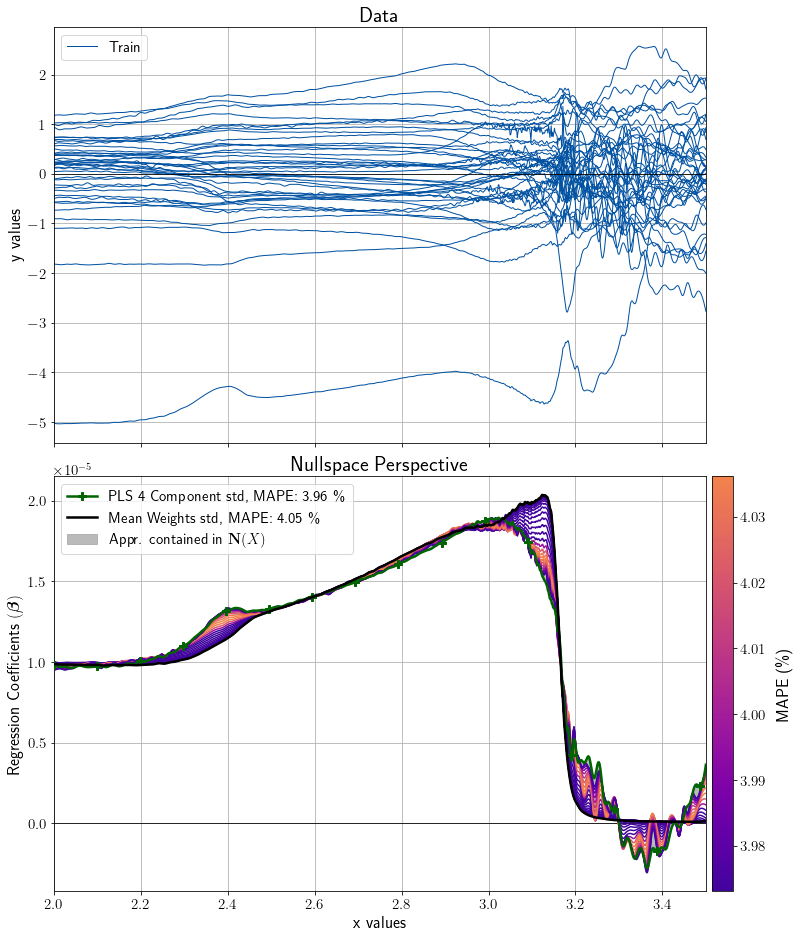

In [31]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha = 'PLS 4 Comp.', w_alpha_name='PLS 4 Component', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_std_4PLS_mean.pdf')

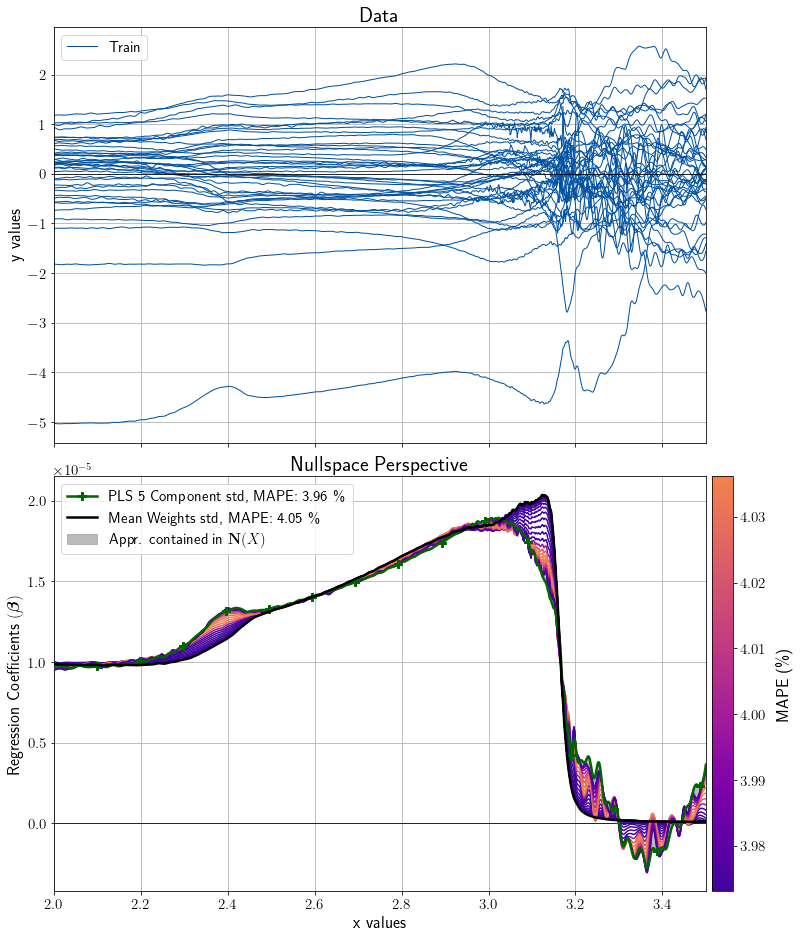

In [32]:
dml_lfp_syn, fig, ax = dml_lfp_syn.nullspace_correction(
    key_alpha = 'PLS 5 Comp.', w_alpha_name='PLS 5 Component', 
    w_beta = mean_reg_coef_lfp, w_beta_name='Mean Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_example_std_5PLS_mean.pdf')

In [33]:
if extra_plots:
    plt.plot(dml_lfp_syn.x, dml_lfp_syn.weights['PLS 1 Comp. std'], label='PLS1, X_std')
    plt.plot(dml_lfp_syn.x, mean_reg_coef_lfp*dml_lfp_syn.std, label='Mean weights*std')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Regression Coefficients')
    plt.legend()
    plt.show()

# Examples with non-constant ground truth!

1. Linearly increasing weight as ground truth

2. Ground truth is weighting by column mean

In [34]:
# Contruct data object
# data LFP Synthethic Linearly Increasing

y_lfps_train_li = np.zeros(X_lfp_train.shape[0])
rcoef_lfp_li = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])
rcoef_lfp_li = np.array([rcoef_lfp_li[i] + (i+X_lfp_train.shape[1])/X_lfp_train.shape[1] for i in range(len(rcoef_lfp_li))])

y_lfps_train_li = np.dot(X_lfp_train, rcoef_lfp_li)

dml_lfps_li = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfps_train_li)

dml_lfps_li = dml_lfps_li.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfps_li = dml_lfps_li.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfps_li = dml_lfps_li.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfps_li = dml_lfps_li.learn_weights(model_PLS4, 'PLS 4 Comp.')

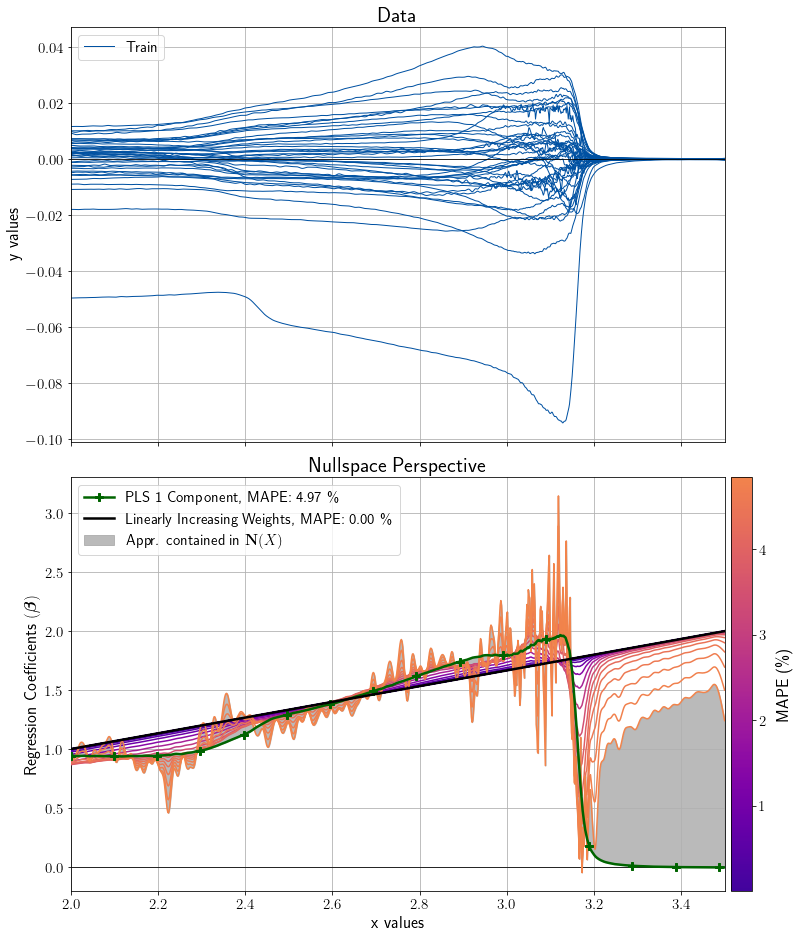

In [35]:
dml_lfps_li, fig, ax = dml_lfps_li.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = rcoef_lfp_li, w_beta_name='Linearly Increasing Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_1PLS_li.pdf')

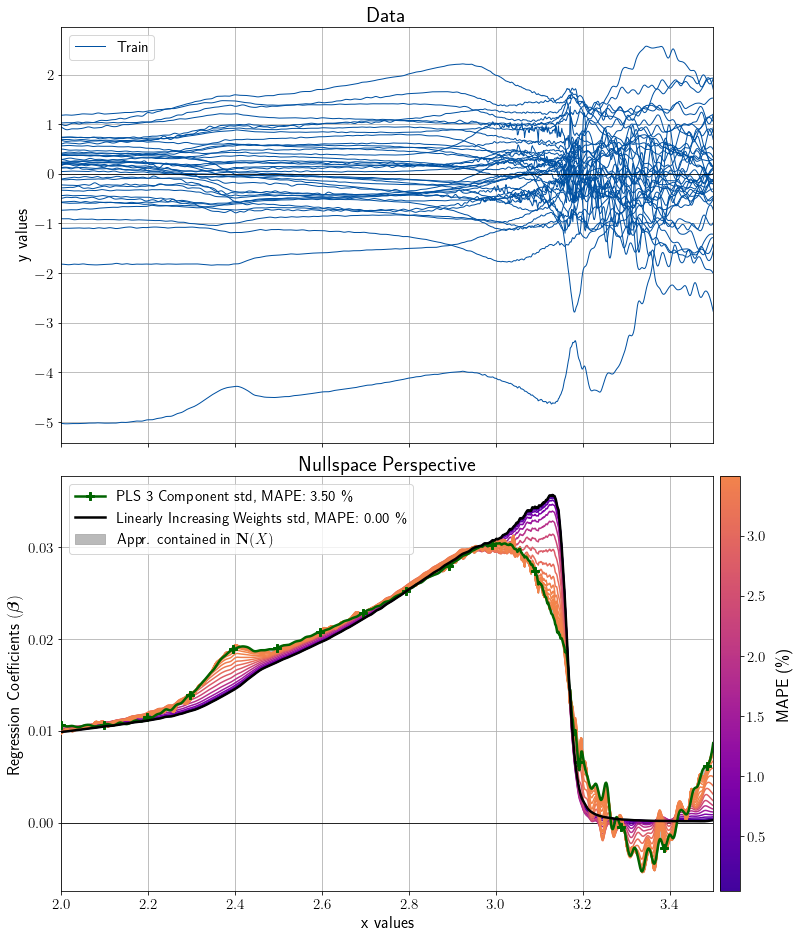

In [36]:
dml_lfps_li, fig, ax = dml_lfps_li.nullspace_correction(
    key_alpha = 'PLS 3 Comp.', w_alpha_name='PLS 3 Component', 
    w_beta = rcoef_lfp_li, w_beta_name='Linearly Increasing Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_3PLS_li_std.pdf')

In [37]:
# Contruct data object
# data LFP Synthethic Linearly decreasing

y_lfps_train_ld = np.zeros(X_lfp_train.shape[0])
rcoef_lfp_ld = (1/X_lfp_train.shape[1]) * np.ones(X_lfp_train.shape[1])
rcoef_lfp_ld = np.array([rcoef_lfp_ld[i] - (i-X_lfp_train.shape[1])/X_lfp_train.shape[1] for i in range(len(rcoef_lfp_ld))])

y_lfps_train_ld = np.dot(X_lfp_train, rcoef_lfp_ld)

dml_lfps_ld = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfps_train_ld)

dml_lfps_ld = dml_lfps_ld.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfps_ld = dml_lfps_ld.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfps_ld = dml_lfps_ld.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfps_ld = dml_lfps_ld.learn_weights(model_PLS4, 'PLS 4 Comp.')

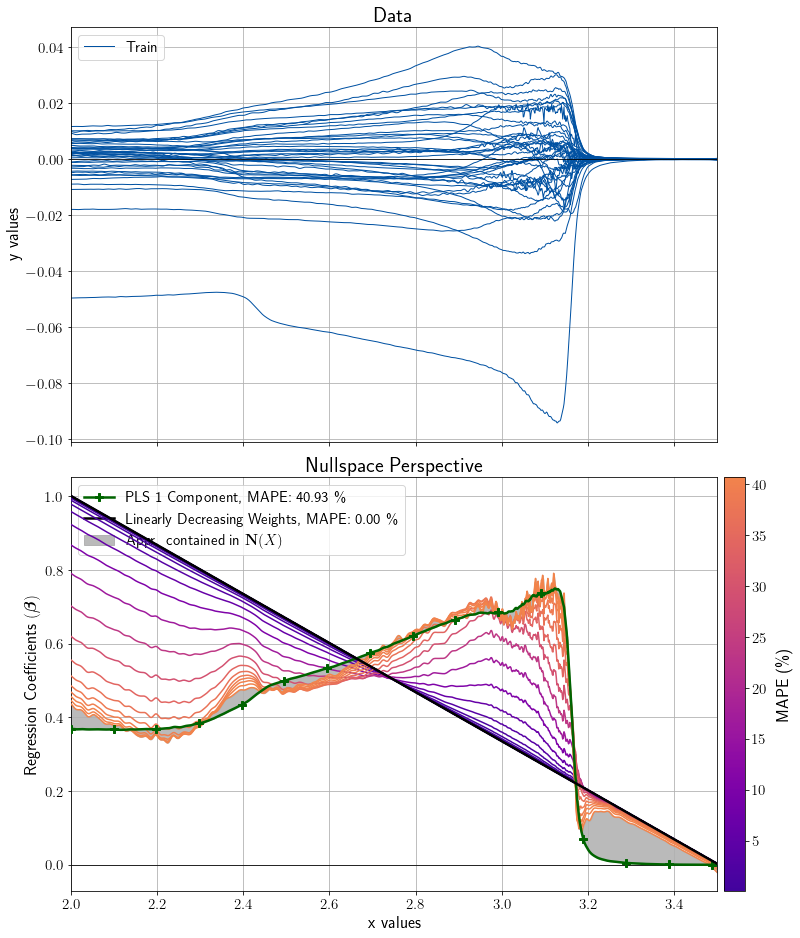

In [38]:
dml_lfps_ld, fig, ax = dml_lfps_ld.nullspace_correction(
    key_alpha = 'PLS 1 Comp.', w_alpha_name='PLS 1 Component', 
    w_beta = rcoef_lfp_ld, w_beta_name='Linearly Decreasing Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_1PLS_ld.pdf')

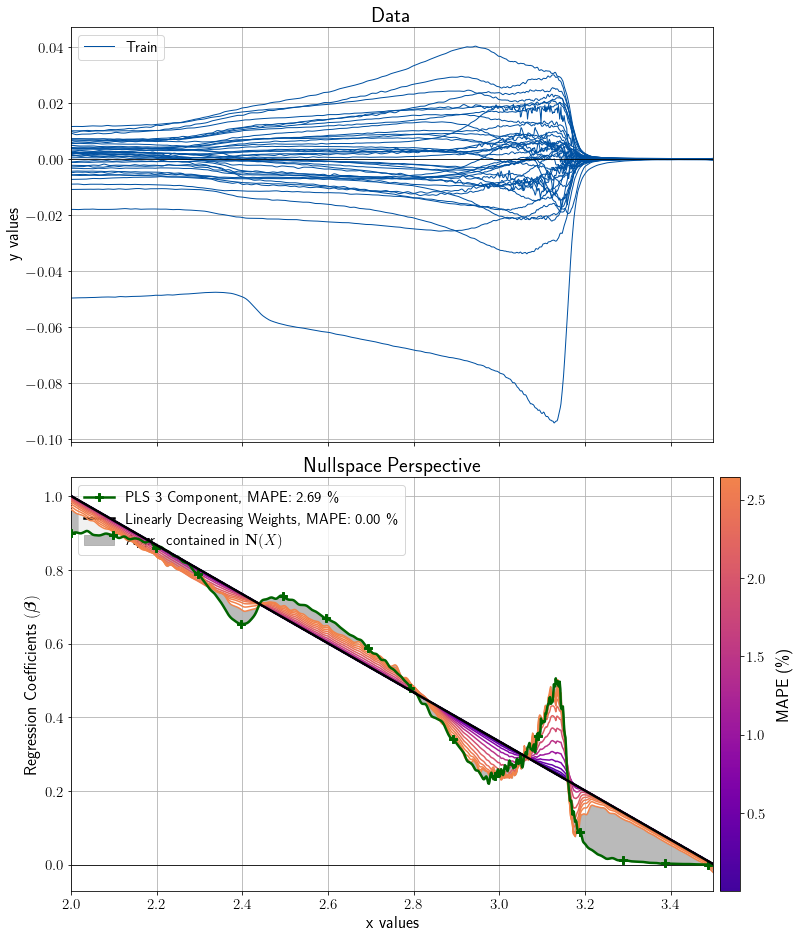

In [39]:
dml_lfps_ld, fig, ax = dml_lfps_ld.nullspace_correction(
    key_alpha = 'PLS 3 Comp.', w_alpha_name='PLS 3 Component', 
    w_beta = rcoef_lfp_ld, w_beta_name='Linearly Decreasing Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_3PLS_ld.pdf')

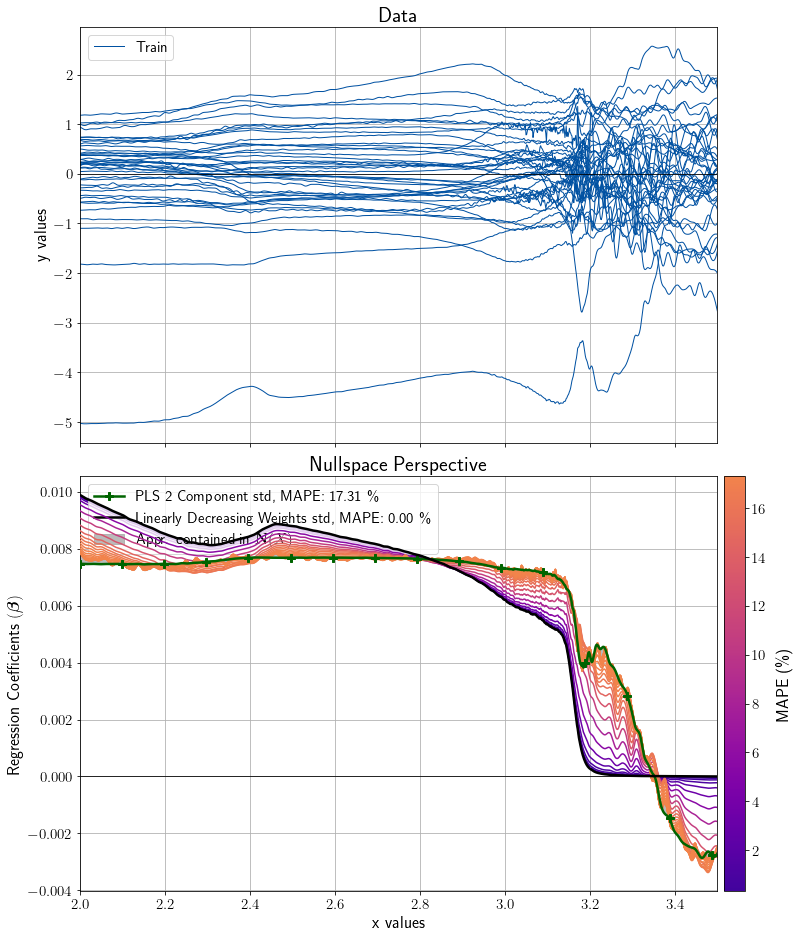

In [40]:
dml_lfps_ld, fig, ax = dml_lfps_ld.nullspace_correction(
    key_alpha = 'PLS 2 Comp.', w_alpha_name='PLS 2 Component', 
    w_beta = rcoef_lfp_ld, w_beta_name='Linearly Decreasing Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_2PLS_ld_std.pdf')

### Colum mean weights

In [42]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column_mean 

rcoef_lfp_cm =  np.mean(X_lfp_train, axis=0)

if not load_data: 
    y_lfps_train_cm = np.dot(X_lfp_train, rcoef_lfp_cm)

    dml_lfps_cm = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfps_train_cm)
    # Add noise to target values
    dml_lfps_cm = dml_lfps_cm.add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)
    if save_data: 
        np.savetxt(
            "lfp_y_cm.csv", dml_lfps_cm.y, delimiter=",", 
            header="Column Mean response for the LFP Data")
else:
    dml_lfps_cm = basis.SynMLData(None, None).place_X_y(
        X_lfp_train, x_lfp, np.loadtxt('lfp_y_cm.csv', skiprows=1, delimiter=','))

dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 4 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 5 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 6 Comp.')
dml_lfps_cm = dml_lfps_cm.learn_weights(model_PLS4, 'PLS 7 Comp.')

(array([6.88552151e-05, 1.84344246e-05, 1.16838999e-05, 9.72247408e-06,
        8.96153878e-06, 1.17978373e-05, 1.13559374e-05, 9.72941342e-06,
        9.92059159e-06, 9.86862565e-06]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

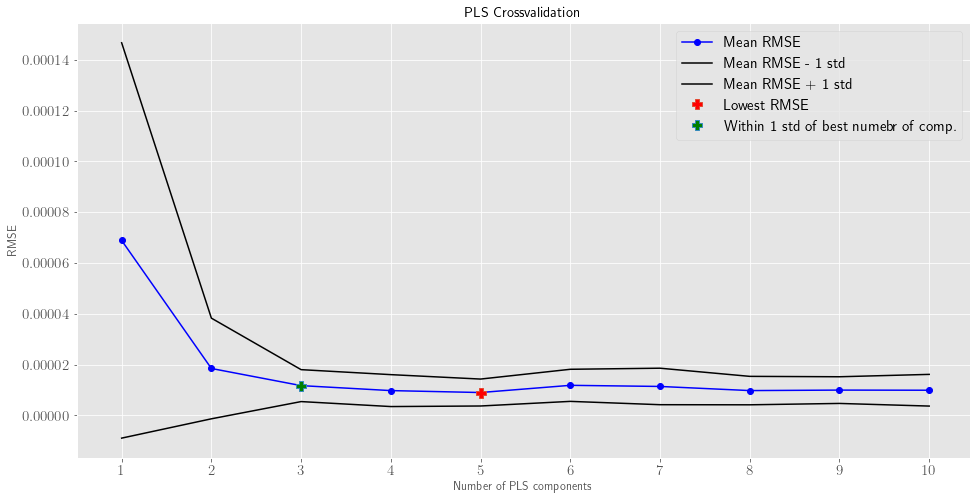

In [43]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=False)

(array([1.82973953e-03, 9.83120762e-04, 9.50104604e-05, 4.60664187e-05,
        1.89357005e-05, 1.25786015e-05, 1.20662301e-05, 1.63627021e-05,
        1.78372956e-05, 2.64740773e-05]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8))

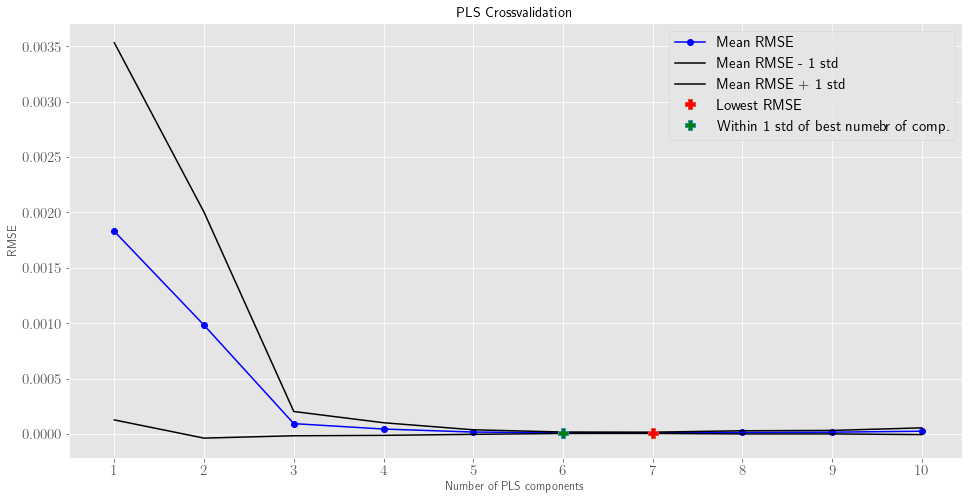

In [44]:
optimise_pls_cv(dml_lfps_cm.X_, dml_lfps_cm.y_, max_comps=10, plot_components=True, std=True)

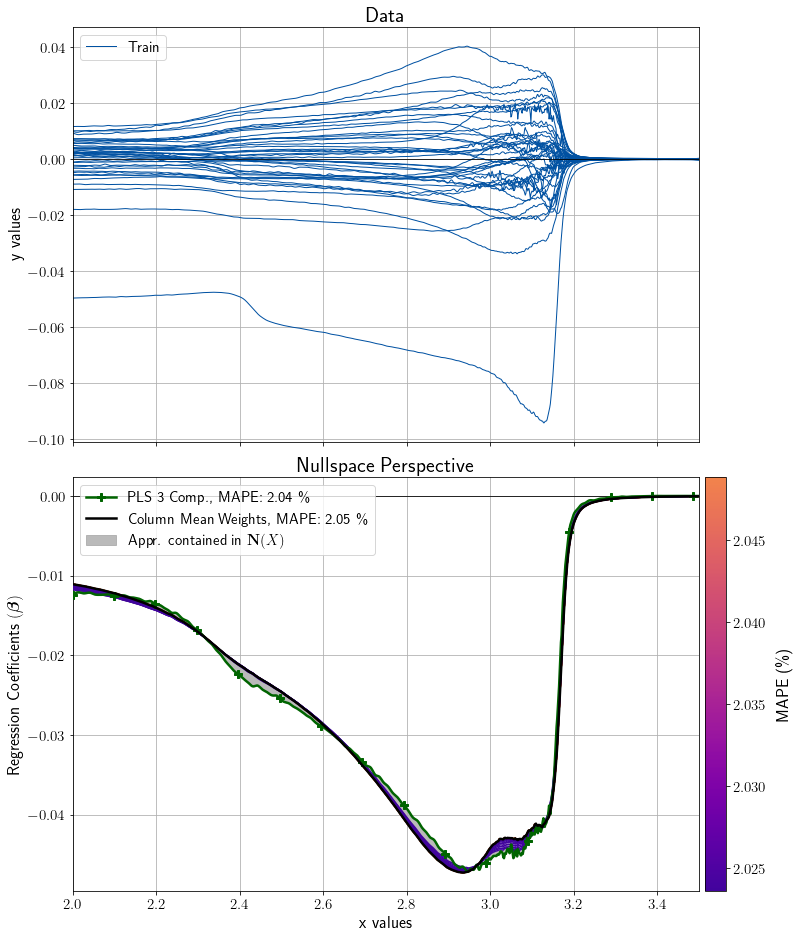

In [ ]:
dml_lfps_cm, fig, ax = dml_lfps_cm.nullspace_correction(
    key_alpha ='PLS 3 Comp.', w_alpha_name='PLS 3 Comp.', 
    w_beta = rcoef_lfp_cm, w_beta_name='Column Mean Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_3PLS_cm.pdf')

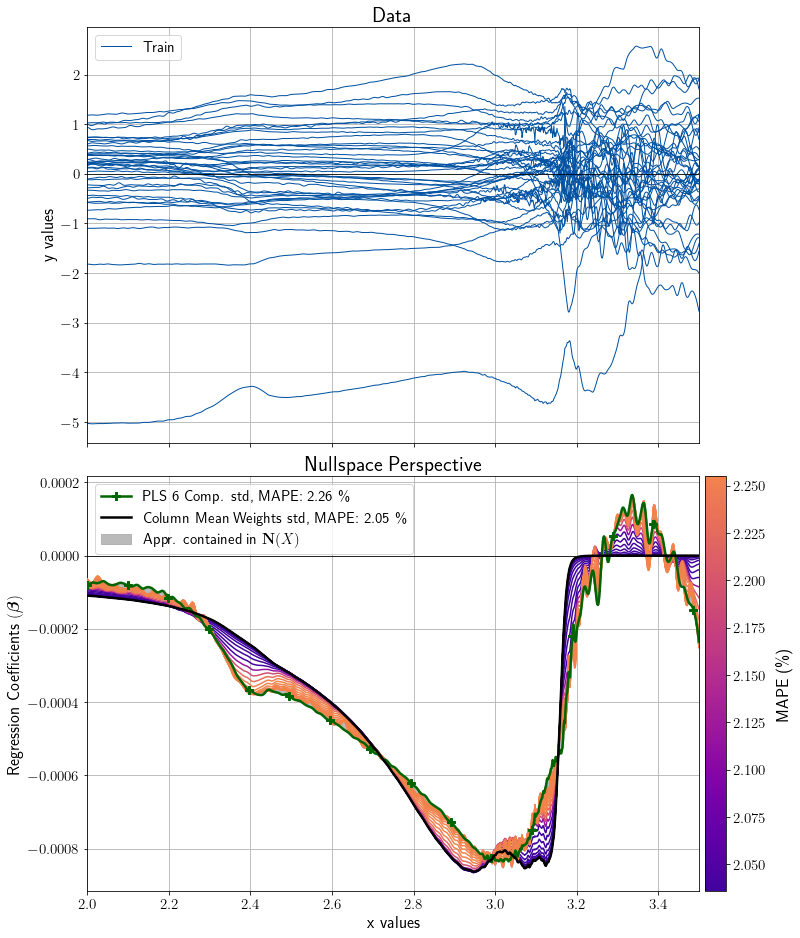

In [ ]:
dml_lfps_cm, fig, ax = dml_lfps_cm.nullspace_correction(
    key_alpha ='PLS 6 Comp.', w_alpha_name='PLS 6 Comp.', 
    w_beta = rcoef_lfp_cm, w_beta_name='Column Mean Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_6PLS_cm.pdf')

In [ ]:
# Contruct data object
# data LFP Synthethic YTrue repsonse is X@column std 

rcoef_lfp_std =  np.std(X_lfp_train, axis=0)
y_lfps_train_std = np.dot(X_lfp_train, rcoef_lfp_std)

dml_lfps_std = basis.SynMLData(None, None).place_X_y(X_lfp_train, x_lfp, y_lfps_train_std)

dml_lfps_std = dml_lfps_std.learn_weights(model_PLS1, 'PLS 1 Comp.')
dml_lfps_std = dml_lfps_std.learn_weights(model_PLS2, 'PLS 2 Comp.')
dml_lfps_std = dml_lfps_std.learn_weights(model_PLS3, 'PLS 3 Comp.')
dml_lfps_std = dml_lfps_std.learn_weights(model_PLS4, 'PLS 4 Comp.')

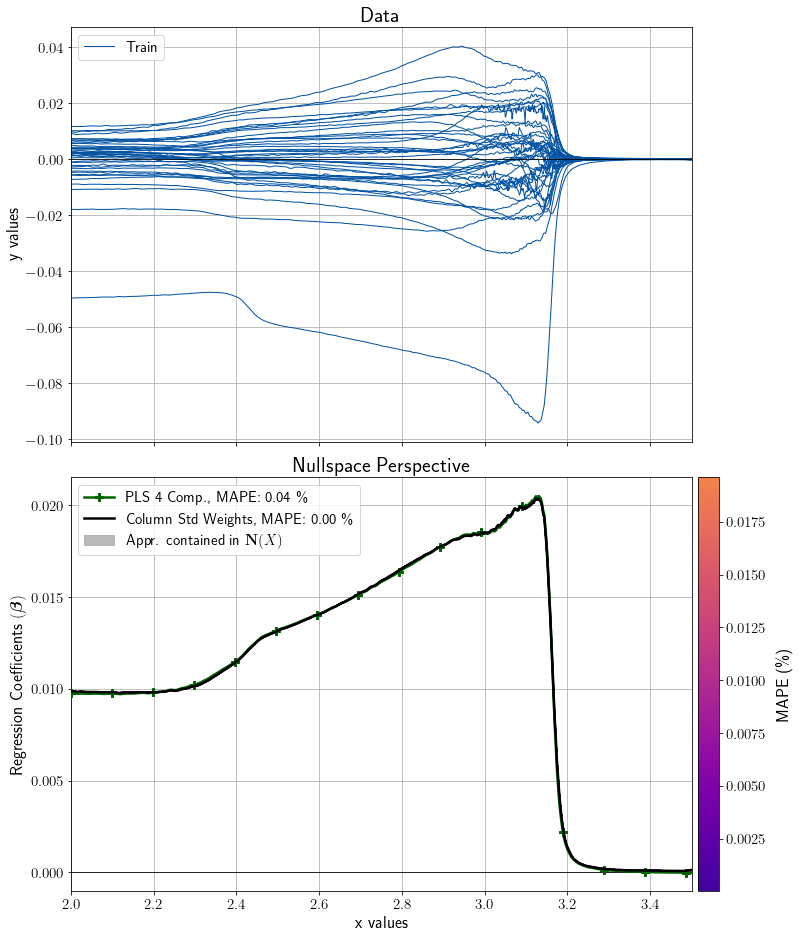

In [ ]:
dml_lfps_std, fig, ax = dml_lfps_std.nullspace_correction(
    key_alpha ='PLS 4 Comp.', w_alpha_name='PLS 4 Comp.', 
    w_beta = rcoef_lfp_std, w_beta_name='Column Std Weights', std=False,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_4PLS_stdf.pdf')

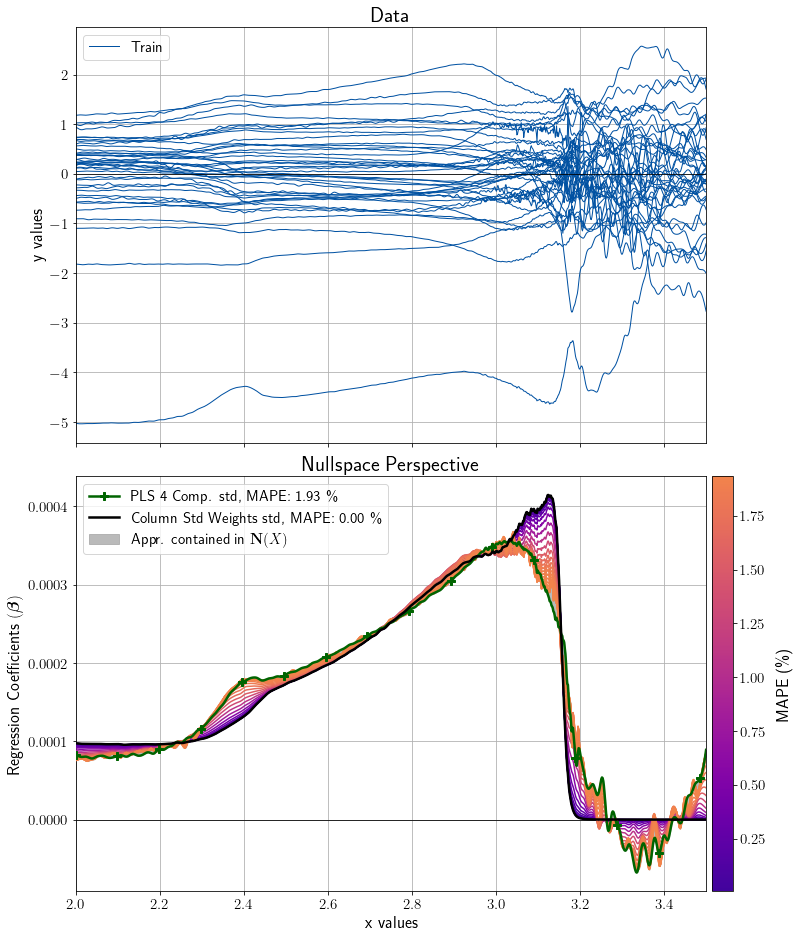

In [ ]:
dml_lfps_std, fig, ax = dml_lfps_std.nullspace_correction(
    key_alpha ='PLS 4 Comp.', w_alpha_name='PLS 4 Comp.', 
    w_beta = rcoef_lfp_std, w_beta_name='Column Std Weights', std=True,
    plot_results=True, save_plot=save_plots, path_save=save_plot_path, file_name='LFP_4PLS_stdf_std.pdf')